<a href="https://colab.research.google.com/github/duypham01/PDENet/blob/main/InverseDiffEq_find_F_27_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import time
import json
import tensorflow.keras as keras
import tensorflow_probability as tfp

In [ ]:
def u_exact(x,t):
    return np.exp(-np.pi**2*t)*np.sin(np.pi*x)
def generateObservation(h, x_arr, delta_t, t_0, n_t):
    x = []
    tmp = x_arr[0]
    while tmp <= x_arr[1]:
        x.append(tmp)
        tmp = tmp + h
    U = []
    t = []
    for i in range(n_t):
        t_tmp = t_0 + i*delta_t
        t.append(t_tmp)
        tmp = []
        for el in x:
            tmp.append(u_exact(el, t_tmp))
        U.append(tmp)
    return U, x, t

In [ ]:
U, x, t = generateObservation(0.0075, [-1,1], 0.02, 0.1, 20)

In [ ]:
x

In [ ]:
len(U[0])

267

In [ ]:
# BUILD NETWORK

# dimension of input and output
in_dim = 2
out_dim = 1

# number of neurons on each layer
nn = [16, 16, 16]

# input layer
inputs = keras.Input(shape=(in_dim,), name='points')

# hidden layers
hidden = keras.layers.Dense(nn[0], activation='tanh', name='hidden_1')(inputs)
for i in range(len(nn)-1):
    hidden = keras.layers.Dense(nn[i+1], activation='tanh', name='hidden_' + str(i+2))(hidden)

# output layer
outputs = keras.layers.Dense(out_dim, activation='linear', name="u")(hidden)

# create network
PDEmodel = keras.Model(inputs=inputs, outputs=outputs, name='heat')

# show network details
PDEmodel.summary()

Model: "heat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 points (InputLayer)         [(None, 2)]               0         
                                                                 
 hidden_1 (Dense)            (None, 16)                48        
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 hidden_3 (Dense)            (None, 16)                272       
                                                                 
 u (Dense)                   (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fun_c(x):
    return 1 + tf.math.exp(-(x-0.5)**2)
# return 1D weights
def get_weights():
    w = []
    for layer in PDEmodel.layers[1:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    return w

# get size of weights in each model's layer
sizes_w = []
sizes_b = []
for layer in PDEmodel.layers[1:]:
    weights_biases = layer.get_weights()
    sizes_w.append(weights_biases[0].flatten().size)
    sizes_b.append(weights_biases[1].size)

# convert 1D weights to multi dimension weights in each model's layer
def set_weights(w):
    for i, layer in enumerate(PDEmodel.layers[1:]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)
def train(U, x, t, delta_t, h, epochs, optimizer):
    losses_hist = []
    # x_in = tf.convert_to_tensor(x, dtype=tf.float32)

    if (optimizer == 'adam'):
        optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
        for epoch in range(epochs):
            start_epoch = time.time()
            loss = [0]
            with tf.GradientTape() as tape:
                loss = 0
                for i in range(len(t)-1):
                    for j in range(1,len(x)-1):
                        xt_in = tf.convert_to_tensor([[x[j], t[i]]], dtype=tf.float32)
                        xt_in1 = tf.convert_to_tensor([[x[j], t[i+1]]], dtype=tf.float32)
                        # t_in = tf.reshape(tf.convert_to_tensor(t[i], dtype=tf.float32), [1])
                        loss = loss + tf.math.square(1/delta_t*(U[i+1][j]-U[i][j]) \
                                                    - fun_c(xt_in[0][0])/(h**2)*(U[i][j+1]+U[i][j-1]-2*U[i][j]) \
                                                    -PDEmodel(xt_in)[0][0])
                loss = loss/((len(t)-1)*(len(x)-2))
            grads = tape.gradient(loss, PDEmodel.weights)
            optimizer.apply_gradients(zip(grads, PDEmodel.weights))
            print("[%4s] loss = %12.8f \t %4.3fs" % (epoch, loss, time.time() - start_epoch))
            losses_hist.append(loss.numpy())
    if (optimizer == 'l-bfgs'):
        def function_factory(x):
            def loss_grad(weights):
                start_epoch = time.time()
                with tf.GradientTape() as tape:
                    loss = 0
                    for i in range(len(t)-1):
                        for j in range(1,len(x)-1):
                            x_in = tf.reshape(tf.convert_to_tensor(x[j], dtype=tf.float32), [1])
                            t_in1 = tf.reshape(tf.convert_to_tensor(t[i+1], dtype=tf.float32), [1])
                            t_in = tf.reshape(tf.convert_to_tensor(t[i], dtype=tf.float32), [1])
                    print("loss = %12.5f \t %4.3fs" % (loss, time.time() - start_epoch))
                    losses_hist.append(loss.numpy())
                grad = tape.gradient(loss, PDEmodel.weights)
                grad_1D = []
                for g in grad:
                    grad_1D.append(tf.reshape(g, [-1]))
                grad_1D = tf.concat(grad_1D, 0)
                return loss, grad_1D
            return loss_grad
        # update paremeters

        func = function_factory(x)
        # add loss_batch to loss
        tfp.optimizer.lbfgs_minimize(func,
            tf.convert_to_tensor(get_weights(), dtype=tf.float32),
            max_iterations=epochs)

[   0] loss =   0.00946990 	 19.054s
[   1] loss =   0.00914974 	 19.398s
[   2] loss =   0.00884626 	 18.905s
[   3] loss =   0.00867258 	 19.169s
[   4] loss =   0.00856496 	 18.996s
[   5] loss =   0.00831071 	 18.842s
[   6] loss =   0.00817717 	 19.441s
[   7] loss =   0.00807358 	 19.001s
[   8] loss =   0.00785424 	 18.750s
[   9] loss =   0.00779816 	 18.819s
[  10] loss =   0.00763829 	 19.111s
[  11] loss =   0.00747273 	 18.946s
[  12] loss =   0.00740481 	 19.285s
[  13] loss =   0.00724458 	 18.919s
[  14] loss =   0.00710477 	 18.826s
[  15] loss =   0.00701390 	 19.055s
[  16] loss =   0.00687361 	 19.067s
[  17] loss =   0.00673730 	 19.152s
[  18] loss =   0.00663941 	 18.899s
[  19] loss =   0.00651236 	 19.165s
[  20] loss =   0.00637667 	 19.218s
[  21] loss =   0.00627922 	 18.942s
[  22] loss =   0.00615630 	 18.804s
[  23] loss =   0.00602861 	 18.960s
[  24] loss =   0.00593027 	 18.932s
[  25] loss =   0.00581153 	 19.140s
[  26] loss =   0.00569311 	 18.938s
[

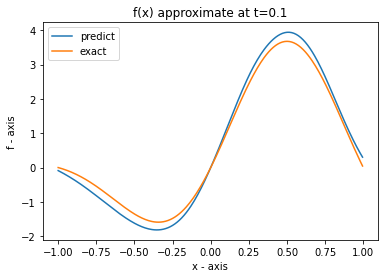

Predict -----------------------------


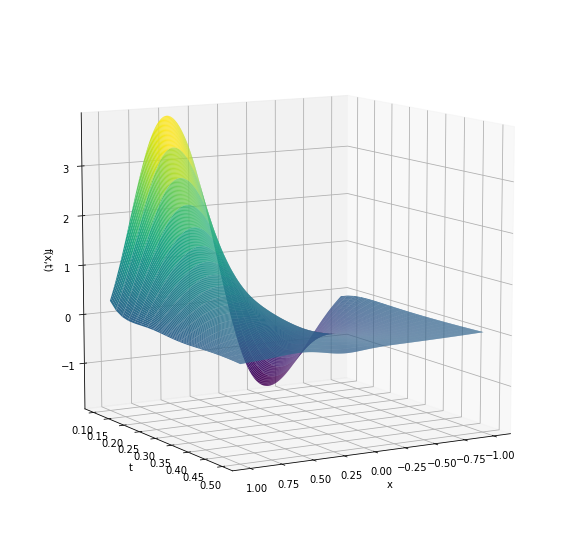

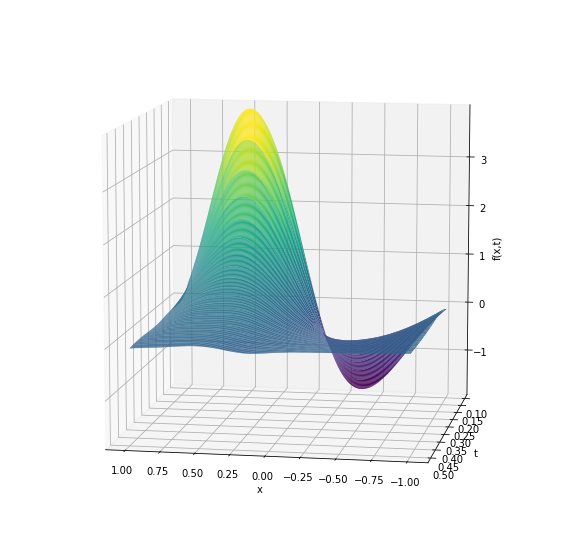

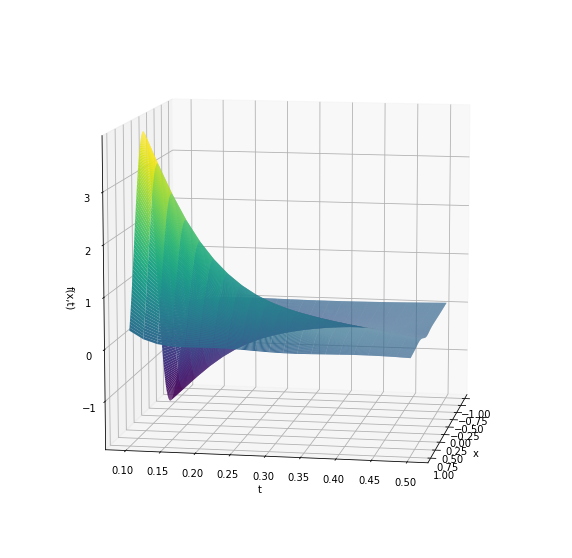

Exact -----------------------------


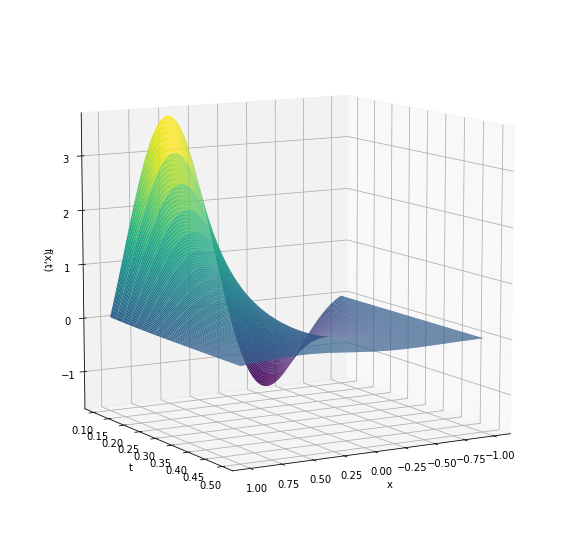

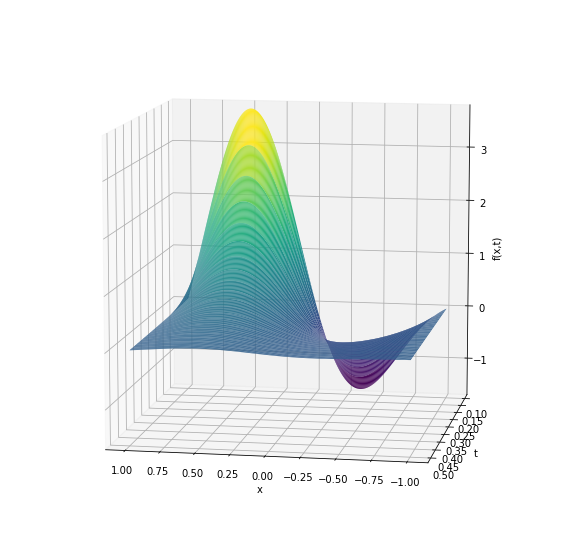

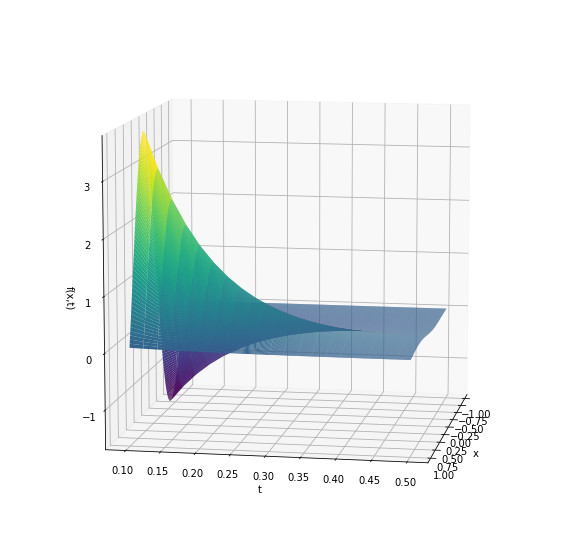

In [ ]:
train(U, x, t, delta_t=0.02, h=0.0075, epochs=300, optimizer='adam')
import matplotlib.pyplot as plt
def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
# line 1 points
x1 = x
y1 = []
t = 0.1
for el in x:
    a = tf.convert_to_tensor([[el, t]], dtype=tf.float32)
    y1.append(PDEmodel(a)[0][0])
# plotting the line 1 points
plt.plot(x1, y1, label = "predict")
 
# line 2 points
x2 = x
y2 = []
for el in x:
    y2.append(f_exact(el, t))
# plotting the line 2 points
plt.plot(x2, y2, label = "exact")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('f - axis')
# giving a title to my graph
plt.title('f(x) approximate at t={}'.format(t))
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    elif n == 1:
        return([start])
    else:
        return([])

def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
 
x_cp = x
# t = np.array(seq(0, 1.0, 1/1440))
t = np.array(seq(0.1, 0.5, 0.02))
# t = np.delete(t, -1)
BB = np.array([])

for i in range(len(t)):
    row = []
    for j in range(len(x_cp)):
        a = tf.convert_to_tensor([[x_cp[j], t[i]]], dtype=tf.float32)
        row.append(PDEmodel(a)[0][0].numpy())
    if (i ==0):
        BB = np.array([row])
    else:
        BB = np.append(BB, np.array([row]), axis=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
print("Predict -----------------------------")
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# -----------------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# --------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# --------------- 
print("Exact -----------------------------")
def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
 
x_cp = x
# t = np.array(seq(0, 1.0, 1/1440))
t = np.array(seq(0.1, 0.5, 0.02))
# t = np.delete(t, -1)
BB = np.array([])

for i in range(len(t)):
    row = []
    for j in range(len(x_cp)):
        row.append(f_exact(x_cp[j], t[i]))
    if (i ==0):
        BB = np.array([row])
    else:
        BB = np.append(BB, np.array([row]), axis=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# -----------------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# --------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

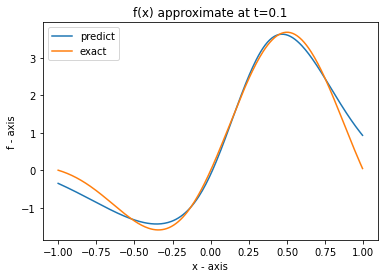

Predict -----------------------------


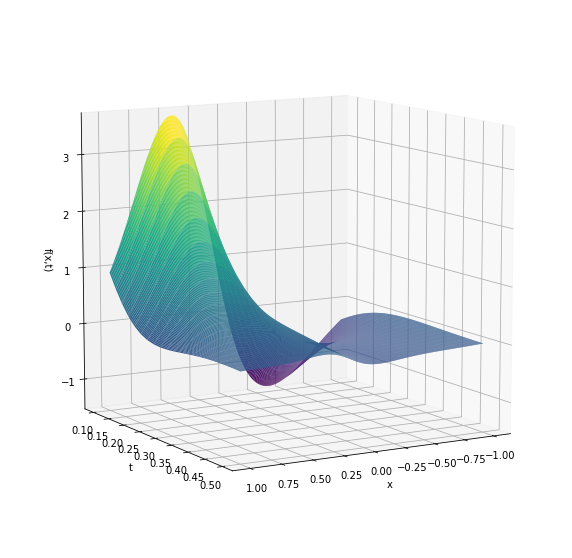

Exact -----------------------------


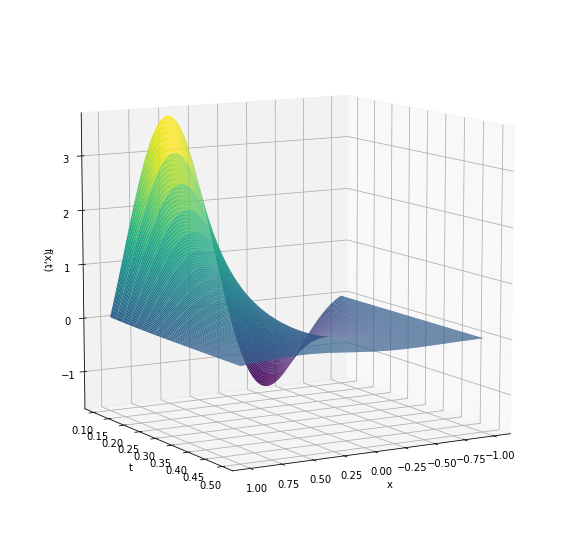

In [ ]:
import matplotlib.pyplot as plt
def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
# line 1 points
x1 = x
y1 = []
t = 0.1
for el in x:
    a = tf.convert_to_tensor([[el, t]], dtype=tf.float32)
    y1.append(PDEmodel(a)[0][0])
# plotting the line 1 points
plt.plot(x1, y1, label = "predict")
 
# line 2 points
x2 = x
y2 = []
for el in x:
    y2.append(f_exact(el, t))
# plotting the line 2 points
plt.plot(x2, y2, label = "exact")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('f - axis')
# giving a title to my graph
plt.title('f(x) approximate at t={}'.format(t))
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    elif n == 1:
        return([start])
    else:
        return([])

def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
 
x_cp = x
# t = np.array(seq(0, 1.0, 1/1440))
t = np.array(seq(0.1, 0.5, 0.02))
# t = np.delete(t, -1)
BB = np.array([])

for i in range(len(t)):
    row = []
    for j in range(len(x_cp)):
        a = tf.convert_to_tensor([[x_cp[j], t[i]]], dtype=tf.float32)
        row.append(PDEmodel(a)[0][0].numpy())
    if (i ==0):
        BB = np.array([row])
    else:
        BB = np.append(BB, np.array([row]), axis=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
print("Predict -----------------------------")
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# -----------------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# --------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# --------------- 
print("Exact -----------------------------")
def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
 
x_cp = x
# t = np.array(seq(0, 1.0, 1/1440))
t = np.array(seq(0.1, 0.5, 0.02))
# t = np.delete(t, -1)
BB = np.array([])

for i in range(len(t)):
    row = []
    for j in range(len(x_cp)):
        row.append(f_exact(x_cp[j], t[i]))
    if (i ==0):
        BB = np.array([row])
    else:
        BB = np.append(BB, np.array([row]), axis=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# -----------------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# --------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()


In [ ]:
def c_exact(x):
    return 1+np.exp(-(x-0.5)**2)

In [ ]:
c_exact(0.9)

1.8521437889662113

[[-0.427536   -0.4307761  -0.43402818 ...  1.0430639   1.0318996
   1.0207891 ]
 [-0.38843662 -0.3915641  -0.3947039  ...  0.9932482   0.982301
   0.9714052 ]
 [-0.34795752 -0.35096407 -0.35398287 ...  0.9363234   0.9256452
   0.9150141 ]
 ...
 [ 0.30217874  0.30092442  0.29965803 ... -0.68607444 -0.68997914
  -0.6938629 ]
 [ 0.3355846   0.33439097  0.33318627 ... -0.77815443 -0.7821689
  -0.7861533 ]
 [ 0.3677094   0.36657092  0.3654211  ... -0.86164606 -0.8658731
  -0.87006086]]


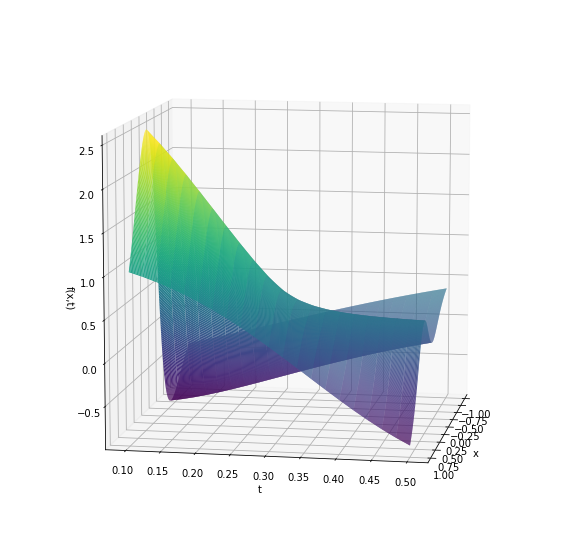

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    elif n == 1:
        return([start])
    else:
        return([])

def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
 
x_cp = x
# t = np.array(seq(0, 1.0, 1/1440))
t = np.array(seq(0.1, 0.5, 0.02))
# t = np.delete(t, -1)
BB = np.array([])

for i in range(len(t)):
    row = []
    for j in range(len(x_cp)):
        a = tf.convert_to_tensor([[x_cp[j], t[i]]], dtype=tf.float32)
        row.append(PDEmodel(a)[0][0].numpy())
    if (i ==0):
        BB = np.array([row])
    else:
        BB = np.append(BB, np.array([row]), axis=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
print("Predict -----------------------------")
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# -----------------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# --------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# --------------- 
print("Exact -----------------------------")
def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
 
x_cp = x
# t = np.array(seq(0, 1.0, 1/1440))
t = np.array(seq(0.1, 0.5, 0.02))
# t = np.delete(t, -1)
BB = np.array([])

for i in range(len(t)):
    row = []
    for j in range(len(x_cp)):
        row.append(f_exact(x_cp[j], t[i]))
    if (i ==0):
        BB = np.array([row])
    else:
        BB = np.append(BB, np.array([row]), axis=0)

print(BB)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# -----------------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# --------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

[[-4.74806373e-17 -4.93070145e-03 -9.97918557e-03 ...  1.09262690e-01
   7.25663620e-02  3.61429265e-02]
 [-3.89753699e-17 -4.04745857e-03 -8.19160126e-03 ...  8.96903244e-02
   5.95674565e-02  2.96685977e-02]
 [-3.19936619e-17 -3.32243213e-03 -6.72422922e-03 ...  7.36239816e-02
   4.88970616e-02  2.43540238e-02]
 ...
 [-1.35970044e-18 -1.41200230e-04 -2.85773396e-04 ...  3.12894974e-03
   2.07807897e-03  1.03502303e-03]
 [-1.11613555e-18 -1.15906852e-04 -2.34582441e-04 ...  2.56845696e-03
   1.70583002e-03  8.49618025e-04]
 [-9.16200760e-19 -9.51443087e-05 -1.92561388e-04 ...  2.10836597e-03
   1.40026250e-03  6.97424858e-04]]


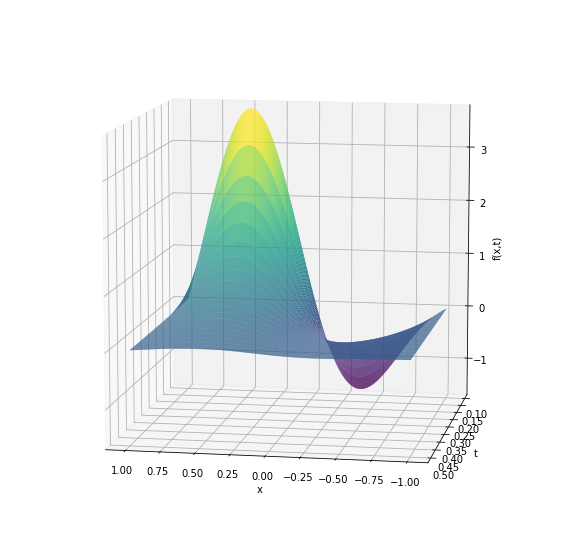

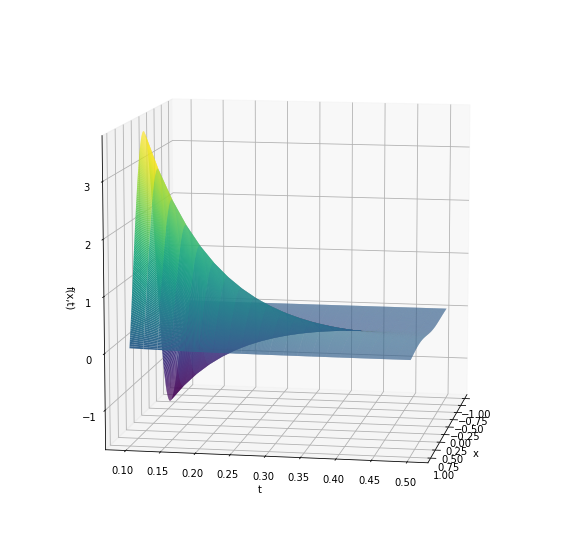

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    elif n == 1:
        return([start])
    else:
        return([])

def f_exact(x, t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)\
        *np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
 
x_cp = x
# t = np.array(seq(0, 1.0, 1/1440))
t = np.array(seq(0.1, 0.5, 0.02))
# t = np.delete(t, -1)
BB = np.array([])

for i in range(len(t)):
    row = []
    for j in range(len(x_cp)):
        row.append(f_exact(x_cp[j], t[i]))
    if (i ==0):
        BB = np.array([row])
    else:
        BB = np.append(BB, np.array([row]), axis=0)

print(BB)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

# -----------------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# --------------------------------
X, T = np.meshgrid(x_cp, t)
ax.plot_surface(X, T, BB , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
plt.show()

In [ ]:
0.1+0.02*20

0.5